## Imports

In [ ]:
import tensorflow as tf
from google.colab import widgets
from IPython.display import display
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
tf.__version__

'2.14.0'

## Prepare Model

In [ ]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)
model.summary()

$$$$

## Import Libraries & Helper Functions

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

$$$$

## Image Processing & Display

In [ ]:
def load_and_process_image(img_path):
  img = load_img(img_path)
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img,axis=0)
  return img

In [ ]:
def deprocess(x):
  # imagenet means
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68

  x = x[:,:,::-1]
  x = np.clip(x,0,255).astype('uint8')
  return x

def display_image(x):
  if len(x.shape) == 4:
    x = np.squeeze(x,axis=0)

  x = deprocess(x)

  plt.figure(figsize=(6,6))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x)

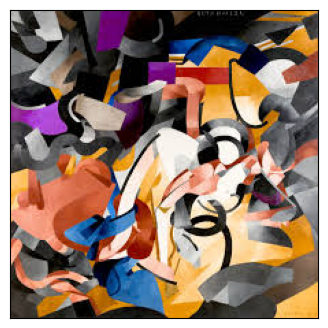

In [ ]:
display_image(load_and_process_image('./style1.jpg'))

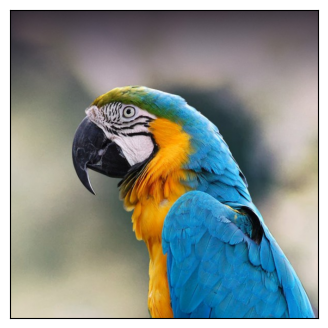

In [ ]:
display_image(load_and_process_image('./parrot.jpg'))

$$$$

## Content and Style Models

> It's recommended to use the content layer as the last layers of the model as it captures the structure of the image, and use the early layers of the CNN to extrat the style of the image.

In [ ]:
content_layer = 'block5_conv2' # @param ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
content_model = Model(model.input,model.get_layer(content_layer).output)

style_layer1 = 'block1_conv1' # @param ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
style_layer2 = 'block3_conv1' # @param ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
style_layer3 = 'block5_conv1' # @param ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
style_layers = [style_layer1,style_layer2,style_layer3]

style_models = [Model(model.input,model.get_layer(layer).output) for layer in style_layers]

$$$$

## Cost Functions

### Content Cost

In [ ]:
def content_cost(content,generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  return tf.reduce_mean(tf.square(a_C-a_G))

### Style Cost

**Gram Matrix**

In [ ]:
def gram_matrix(A):
  n_C = int(A.shape[-1])
  a = tf.reshape(A,[-1,n_C])
  n = tf.shape(a)[0]
  G = tf.matmul(a,a,transpose_a=True)
  return G / tf.cast(n,tf.float32)

In [ ]:
style_image_path = 'style1.jpg' # @param ['style1.jpg','style2.jpg']
style_img = load_and_process_image(style_image_path)
GS_list = []
for style_model in style_models:
  a_S = style_model(style_img)
  GS_list.append(gram_matrix(a_S))

In [ ]:
def style_cost(generated,style = None):
  J_style = 0
  for i,style_model in enumerate(style_models):
    a_G = style_model(generated)
    GG = gram_matrix(a_G)
    GS = GS_list[i]
    current_cost = tf.reduce_mean(tf.square(GG - GS))
    J_style += current_cost / len(style_models)

  return J_style

$$$$

## Training Loop

In [ ]:
content_image = load_and_process_image('parrot.jpg')
def train_loop(iterations = 20,# N° of epochs
               alpha = 10, # content loss coefficient
               beta=20 # style loss coefficient
               ):
  generated = tf.Variable(content_image,tf.float32)
  generated_images = []
  generated_images.append(generated.numpy())
  opt = Adam(learning_rate=7.0)
  best_cost = 1e12
  best_image = None

  for it in tqdm(range(iterations),desc='Epochs'):
    with tf.GradientTape() as tape:
      J_content = content_cost(content_image,generated)
      J_style = style_cost(generated)
      J_total = alpha * J_content + beta * J_style

    grads = tape.gradient(J_total,generated)
    opt.apply_gradients([(grads, generated)])
    generated_images.append(generated.numpy())

    if J_total < best_cost:
      best_cost = J_total
      best_image = generated.numpy()

    print(f'Cost_{it}: {J_total:.3f}')

  return generated_images,best_image

In [ ]:
%%time
generated_images,best_image = train_loop(iterations = 100)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Cost_0: 43230519296.00000
Cost_1: 37884141568.00000
Cost_2: 29287936000.00000
Cost_3: 20554293248.00000
Cost_4: 15427743744.00000
Cost_5: 14270886912.00000
Cost_6: 12485703680.00000
Cost_7: 9830043648.00000
Cost_8: 7710506496.00000
Cost_9: 6481858048.00000
Cost_10: 5813927424.00000
Cost_11: 5369335808.00000
Cost_12: 4994570752.00000
Cost_13: 4645231104.00000
Cost_14: 4309742592.00000
Cost_15: 3976477952.00000
Cost_16: 3643218944.00000
Cost_17: 3320020224.00000
Cost_18: 3018554112.00000
Cost_19: 2745686528.00000
Cost_20: 2501981184.00000
Cost_21: 2285731840.00000
Cost_22: 2094872320.00000
Cost_23: 1927514752.00000
Cost_24: 1781503360.00000
Cost_25: 1653087488.00000
Cost_26: 1538170752.00000
Cost_27: 1434186368.00000
Cost_28: 1340115584.00000
Cost_29: 1255129600.00000
Cost_30: 1177983488.00000
Cost_31: 1107899008.00000
Cost_32: 1044498304.00000
Cost_33: 987361024.00000
Cost_34: 935627200.00000
Cost_35: 888281088.00000
Cost_36: 844690368.00000
Cost_37: 804592576.00000
Cost_38: 767750144.0

$$$$

## Plot the Results

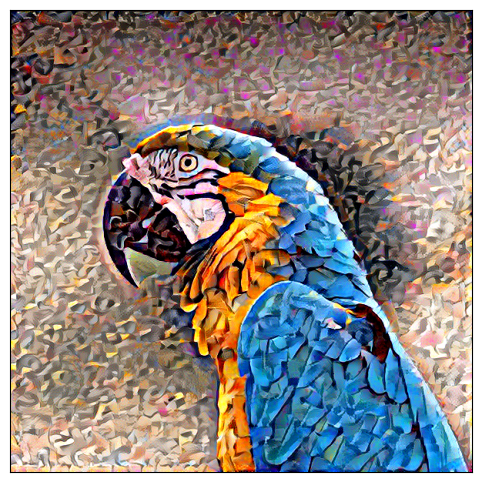

In [ ]:
display_image(best_image)

**Optional-- Plot all the results**

In [ ]:
plt.figure(figsize=(14,14))
for i in range(100):
  plt.subplot(10,10,i+1)
  x = np.squeeze(generated_images[i],axis=0)
  x = deprocess(x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x)

plt.show()